In [1]:
import warnings
import numpy as np
from scipy import linalg
from sklearn.datasets import fetch_olivetti_faces

In [2]:
data = fetch_olivetti_faces()
face_images = data.data
print(face_images.shape)

(400, 4096)


In [3]:
def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)

def _ica_par(X, tol, g, fun_args, max_iter, w_init):
    """Parallel FastICA.
    Used internally by FastICA --main loop
    """
    W = _sym_decorrelation(w_init)
    del w_init
    p_ = float(X.shape[1])
    for ii in range(max_iter):
        gwtx, g_wtx = g(np.dot(W, X), fun_args)
        W1 = _sym_decorrelation(np.dot(gwtx, X.T) / p_
                                - g_wtx[:, np.newaxis] * W)
        del gwtx, g_wtx
        # builtin max, abs are faster than numpy counter parts.
        lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
        W = W1
        if lim < tol:
            break
    else:
        warnings.warn('FastICA did not converge. Consider increasing '
                      'tolerance or the maximum number of iterations.')

    return W, ii + 1

# Some standard non-linear functions.
# XXX: these should be optimized, as they can be a bottleneck.
def _logcosh(x, fun_args=None):
    alpha = fun_args.get('alpha', 1.0)  # comment it out?

    x *= alpha
    gx = np.tanh(x, x)  # apply the tanh inplace
    g_x = np.empty(x.shape[0])
    # XXX compute in chunks to avoid extra allocation
    for i, gx_i in enumerate(gx):  # please don't vectorize.
        g_x[i] = (alpha * (1 - gx_i ** 2)).mean()
    return gx, g_x
def _exp(x, fun_args):
    exp = np.exp(-(x ** 2) / 2)
    gx = x * exp
    g_x = (1 - x ** 2) * exp
    return gx, g_x.mean(axis=-1)
def _cube(x, fun_args):
    return x ** 3, (3 * x ** 2).mean(axis=-1)

def fastica(X, n_components=None, algorithm="parallel", whiten=True,
            fun="cube", fun_args=None, max_iter=200, tol=1e-04, w_init=None,
            random_state=None, return_X_mean=False, compute_sources=True,
            return_n_iter=False):

#     random_state = check_random_state(random_state)
    fun_args = {} if fun_args is None else fun_args
    # make interface compatible with other decompositions
    # a copy is required only for non whitened data
#     X = check_array(X, copy=whiten, dtype=FLOAT_DTYPES).T

    alpha = fun_args.get('alpha', 1.0)
    if not 1 <= alpha <= 2:
        raise ValueError('alpha must be in [1,2]')

    if fun == 'logcosh':
        g = _logcosh
    elif fun == 'exp':
        g = _exp
    elif fun == 'cube':
        g = _cube
    elif callable(fun):
        def g(x, fun_args):
            return fun(x, **fun_args)
    else:
        exc = ValueError if isinstance(fun, six.string_types) else TypeError
        raise exc("Unknown function %r;"
                  " should be one of 'logcosh', 'exp', 'cube' or callable"
                  % fun)

    n, p = X.shape

    if not whiten and n_components is not None:
        n_components = None
        warnings.warn('Ignoring n_components with whiten=False.')

    if n_components is None:
        n_components = min(n, p)
    if (n_components > min(n, p)):
        n_components = min(n, p)
        warnings.warn('n_components is too large: it will be set to %s' % n_components)

    if whiten:
        # Centering the columns (ie the variables)
        X_mean = X.mean(axis=-1)
        X -= X_mean[:, np.newaxis]

        # Whitening and preprocessing by PCA
        u, d, _ = linalg.svd(X, full_matrices=False)

        del _
        K = (u / d).T[:n_components]  # see (6.33) p.140
        del u, d
        X1 = np.dot(K, X)
        # see (13.6) p.267 Here X1 is white and data
        # in X has been projected onto a subspace by PCA
        X1 *= np.sqrt(p)
    else:
        # X must be casted to floats to avoid typing issues with numpy
        # 2.0 and the line below
        
#         X1 = as_float_array(X, copy=False)  # copy has been taken care of
        X1 = X.astype(np.float64).copy()

    if w_init is None:
#         w_init = np.asarray(random_state.normal(size=(n_components,n_components)), dtype=X1.dtype)
        w_init =  np.random.normal(size=(n_components,n_components))

    else:
        w_init = np.asarray(w_init)
        if w_init.shape != (n_components, n_components):
            raise ValueError('w_init has invalid shape -- should be %(shape)s'
                             % {'shape': (n_components, n_components)})

    kwargs = {'tol': tol,
              'g': g,
              'fun_args': fun_args,
              'max_iter': max_iter,
              'w_init': w_init}

    if algorithm == 'parallel':
        W, n_iter = _ica_par(X1, **kwargs)
    elif algorithm == 'deflation':
        W, n_iter = _ica_def(X1, **kwargs)
    else:
        raise ValueError('Invalid algorithm: must be either `parallel` or'
                         ' `deflation`.')
    del X1

    if whiten:
        if compute_sources:
            S = np.dot(np.dot(W, K), X).T
        else:
            S = None
        if return_X_mean:
            if return_n_iter:
                return K, W, S, X_mean, n_iter
            else:
                return K, W, S, X_mean
        else:
            if return_n_iter:
                return K, W, S, n_iter
            else:
                return K, W, S

    else:
        if compute_sources:
            S = np.dot(W, X).T
        else:
            S = None
        if return_X_mean:
            if return_n_iter:
                return None, W, S, None, n_iter
            else:
                return None, W, S, None
        else:
            if return_n_iter:
                return None, W, S, n_iter
            else:
                return None, W, S

In [28]:
algo = fastica(face_images.T,n_components=100,max_iter=10000,tol=1e-10,whiten=True,compute_sources=True)

In [29]:
print(len(algo))
print(algo[0].shape)
print(algo[1].shape)
print(algo[2].shape)


3
(100, 4096)
(100, 100)
(400, 100)


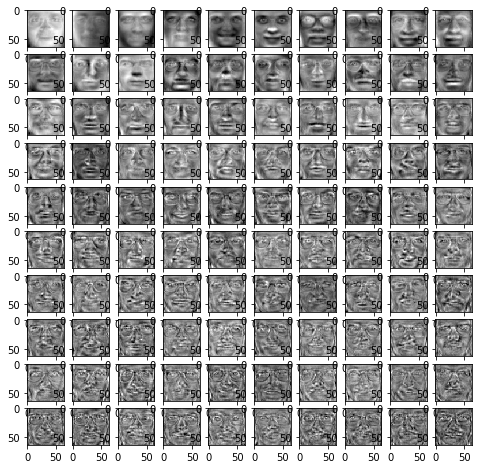

In [23]:
import matplotlib.pyplot as plt
algo_show = algo[0].reshape(100,64,64)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(algo_show[i-1],cmap='gray')
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(100, 64, 64)


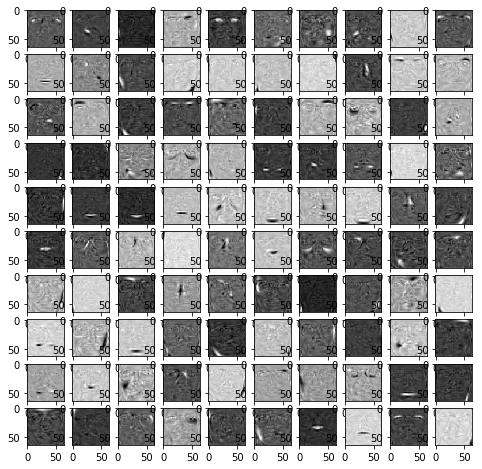

In [6]:
from sklearn.decomposition import FastICA
ee = FastICA(n_components=100,max_iter=1000,tol=1e-10)
ddddd = ee.fit_transform(face_images.T).T.reshape(100,64,64)
print(ddddd.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(ddddd[i-1],cmap='gray')
    except:
        pass
plt.show()

In [8]:
eee = FastICA(n_components=100,max_iter=1000,tol=1e-10)
eee.fit(face_images.T)
print(dir(eee))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fit', '_get_param_names', 'algorithm', 'components_', 'fit', 'fit_transform', 'fun', 'fun_args', 'get_params', 'inverse_transform', 'max_iter', 'mean_', 'mixing_', 'n_components', 'n_iter_', 'random_state', 'set_params', 'tol', 'transform', 'w_init', 'whiten', 'whitening_']


In [20]:
print(eee.mean_.sum())
print(eee.mean_.mean())

print(face_images.mean(1).sum())
print(face_images.mean(1).mean())

218.81699
0.5470425
218.81699
0.5470425


In [12]:
print(eee.whitening_.shape)

(100, 400)


In [13]:
print(eee.components_.shape)

(100, 400)


In [14]:
! git add .
! git commit -m "from mac"
! git push

[master df355761] from mac
 1 file changed, 459 insertions(+), 415 deletions(-)
 rewrite Understanding_Concepts/RICA_FASTICA/y_reference/Untitled.ipynb (92%)
Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 220.62 KiB | 12.98 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   18afedbf..df355761  master -> master
